In [13]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import glob
%matplotlib inline
from lesson import *

Step 1: Read the images and segregate them into two groups car group and non-car group

In [4]:
#read images for both car images and non car images
def readimage(carpath, noncarpath):
    cars = []
    notcars = []
    carimages = glob.glob(carpath)
    notcarimages = glob.glob(noncarpath)
    for carimage in carimages:
        cars.append(carimage)
    for notcarimage in notcarimages:
        notcars.append(notcarimage)
    return cars,notcars

Step 2: Extract features. In this step I followed the same step as lectures notes, and combined color space features, histogram features, and hog features into one single feature vector.

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


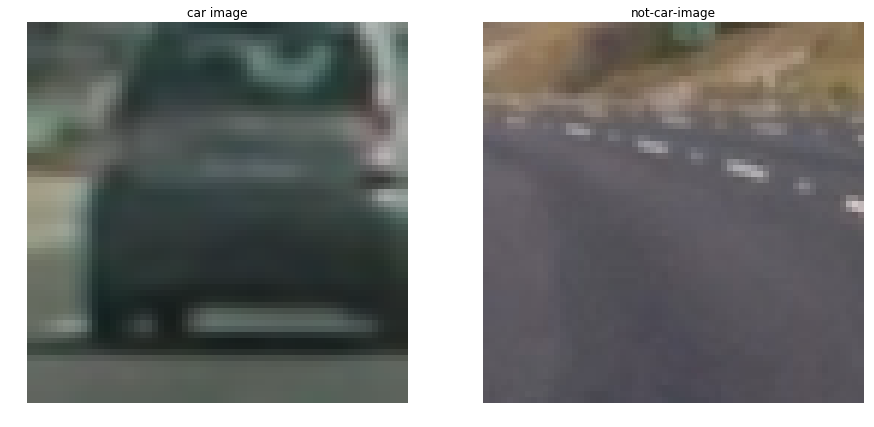

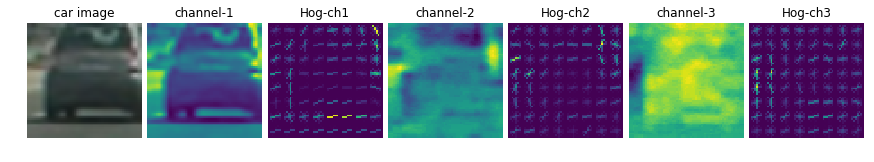

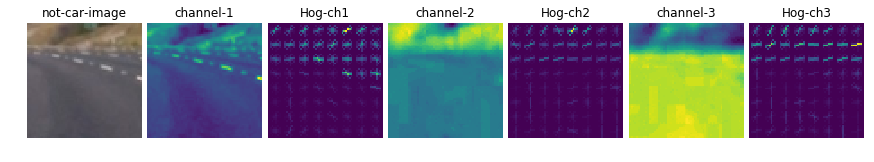

In [17]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

carpath = 'images/vehicles/*/*.png'
noncarpath = 'images/non-vehicles/*/*.png'
cars = [imgpath for imgpath in glob.glob(carpath)]
notcars = [imgpath for imgpath in glob.glob(noncarpath)]
ind = 50
imgs = [cars[ind], notcars[ind]]
titles = ['car image','not-car-image']

f, ax = plt.subplots(1, 2, figsize=(15,12))
ax[0].imshow(mpimg.imread(imgs[0]));
ax[0].set_title(titles[0])
ax[0].axis('off')   
ax[1].imshow(mpimg.imread(imgs[1]));
ax[1].set_title(titles[1])
ax[1].axis('off')  

# #plot the images
for i,img in  enumerate(imgs):
    f, ax = plt.subplots(1, 7,figsize=(15,10))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    img = mpimg.imread(img)
    ax[0].imshow(img);
    ax[0].set_title(titles[i])
    ax[0].axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    for channel in range(img.shape[2]):
        nindex = 1+channel*2
        ax[nindex].imshow(img[:,:,channel])
        title = "channel-{0}".format(channel+1)
        ax[nindex].set_title(title)
        ax[nindex].axis('off')
        feature,image = get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)
        title = "Hog-ch{0}".format(channel+1)
        ax[nindex+1].imshow(image)
        ax[nindex+1].set_title(title)
        ax[nindex+1].axis('off')

Step 3:  Train the model with linear support vector machine.

In [18]:
def train(carpath, noncarpath):

    cars, notcars = readimage(carpath, noncarpath)
    ind = np.random.randint(0,len(cars))
    car = mpimg.imread(cars[ind])


    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, 600] # Min and max in y to search in slide_window()


    car_features = extract_features(cars, color_space=color_space, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)            
    print(X.shape)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
      #data saving
    svc_data = {}
    svc_data["svc"] = svc
    svc_data["scaler"] = X_scaler
    svc_data["orient"] = orient
    svc_data["pix_per_cell"] = pix_per_cell
    svc_data["cell_per_block"] = cell_per_block
    svc_data["spatial_size"] = spatial_size
    svc_data["hist_bins"] = hist_bins
    pickle.dump(svc_data,open("svc_pickle.p", "wb" ))

Step 4: Saved the trained model with pickle files

In [19]:
carpath = 'images/vehicles/*/*.png'
noncarpath = 'images/non-vehicles/*/*.png'
cars, notcars = readimage(carpath, noncarpath)
ind = np.random.randint(0,len(cars))
car = mpimg.imread(cars[ind])
color_space = 'YCrCb'
feature_image = cv2.cvtColor(car, cv2.COLOR_RGB2YCrCb)
# X_scaler = StandardScaler().fit()
#   Apply the scaler to X
# scaled_X = X_scaler.transform(car)
train(carpath, noncarpath)

/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(17760, 6156)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
48.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
